In [5]:
import zipfile
import os

zip_path = "/content/dataset.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
import os

dataset_path = "/content/dataset"
items_path = os.path.join(dataset_path, "items")
json_path = os.path.join(dataset_path, "json")
mask_path = os.path.join(dataset_path, "mask")

items_files = sorted(os.listdir(items_path))
json_files = sorted(os.listdir(json_path))
mask_files = sorted(os.listdir(mask_path))

assert len(items_files) == len(json_files) == len(mask_files) == 132, "Ошибка: количество файлов не совпадает!"

for i, (item_file, json_file, mask_file) in enumerate(zip(items_files, json_files, mask_files), start=1):
    new_item_name = f"{i}.jfif"
    new_json_name = f"{i}.json"
    new_mask_name = f"{i}.png"

    os.rename(os.path.join(items_path, item_file), os.path.join(items_path, new_item_name))
    os.rename(os.path.join(json_path, json_file), os.path.join(json_path, new_json_name))
    os.rename(os.path.join(mask_path, mask_file), os.path.join(mask_path, new_mask_name))

print("Файлы поменял на номерные")

Файлы поменял на номерные


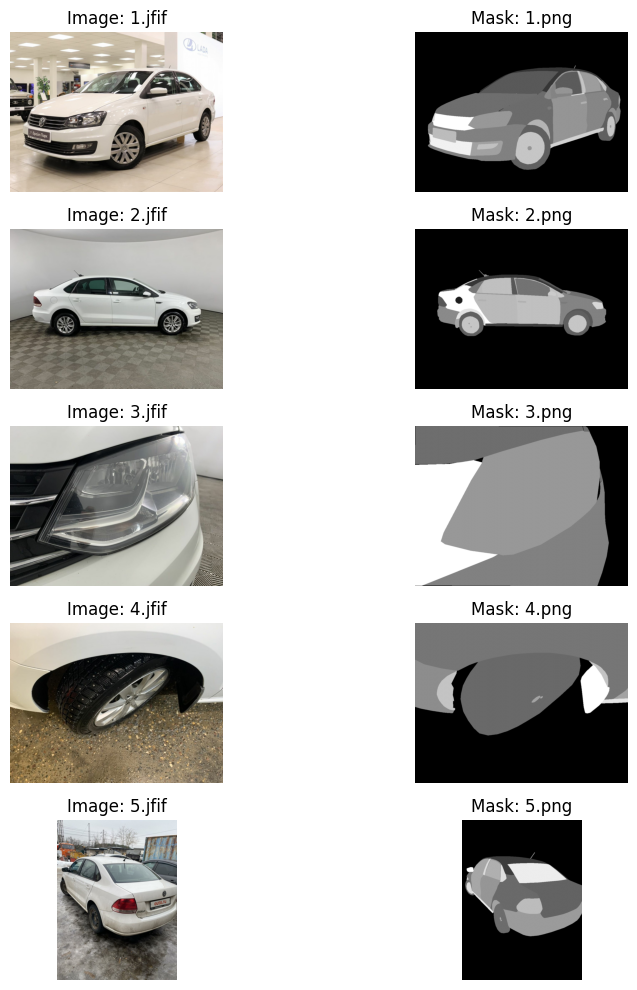

In [7]:
import matplotlib.pyplot as plt
import cv2
import os


images_path = "/content/dataset/items"
masks_path = "/content/dataset/mask"

image_files = sorted(os.listdir(images_path), key=lambda x: int(os.path.splitext(x)[0]))
mask_files = sorted(os.listdir(masks_path), key=lambda x: int(os.path.splitext(x)[0]))
num_samples = 5
num_samples = min(num_samples, len(image_files), len(mask_files))

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i in range(num_samples):
    img = cv2.imread(os.path.join(images_path, image_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(masks_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image: {image_files[i]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title(f"Mask: {mask_files[i]}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

Переименовал верно, можно двигаться дальше

конвертация json в yolo bbox

In [8]:
import os
import json
import cv2

dataset_path = "dataset"
images_path = os.path.join(dataset_path, "items")
jsons_path = os.path.join(dataset_path, "json")
output_labels_path = os.path.join(dataset_path, "labels")

os.makedirs(output_labels_path, exist_ok=True)

class_mapping = {
    "Крупные детали.Бампер задний": 0,
    "Крупные детали.Бампер передний": 1,
    "Крупные детали.Дверь задняя левая": 2,
    "Крупные детали.Дверь задняя правая": 3,
    "Крупные детали.Дверь передняя левая": 4,
    "Крупные детали.Дверь передняя правая": 5,
    "Крупные детали.Капот": 6,
    "Крупные детали.Колесо": 7,
    "Крупные детали.Крыло заднее левое": 8,
    "Крупные детали.Крыло заднее правое": 9,
    "Крупные детали.Крыло переднее левое": 10,
    "Крупные детали.Крыло переднее правое": 11,
    "Крупные детали.Крыша": 12,
    "Крупные детали.Крышка багажника": 13,
    "Крупные детали.Лобовое стекло": 14,
    "Крупные детали.Стекло кузова заднее": 15,
    "Мелкие детали.Антенна": 16,
    "Мелкие детали.Болты крепления диска колеса": 17,
    "Мелкие детали.Заглушка буксировочного крюка бампера переднего": 18,
    "Мелкие детали.Заглушка для диска колеса": 19,
    "Мелкие детали.Крышка бокового зеркала левая": 20,
    "Мелкие детали.Крышка бокового зеркала правая": 21,
    "Мелкие детали.Левая щетка стеклоочистителя на лобовое стекло": 22,
    "Мелкие детали.Левый поводок стеклоочистителя на лобовое стекло": 23,
    "Мелкие детали.Молдинг стекла двери задней левой наружный": 24,
    "Мелкие детали.Молдинг стекла двери задней правой наружный": 25,
    "Мелкие детали.Молдинг стекла двери передней левой наружный": 26,
    "Мелкие детали.Молдинг стекла двери передней правой наружный": 27,
    "Мелкие детали.Ниппель автомобильный для колеса": 28,
    "Мелкие детали.Повторитель": 29,
    "Мелкие детали.Правая щетка стеклоочистителя на лобовое стекло": 30,
    "Мелкие детали.Правый поводок стеклоочистителя на лобовое стекло": 31,
    "Мелкие детали.ПТФ левый": 32,
    "Мелкие детали.ПТФ правый": 33,
    "Мелкие детали.Решетка стеклоочистителя (Накладка жабо под стеклоочистители)": 34,
    "Мелкие детали.Ручка двери": 35,
    "Мелкие детали.Фонарь катафот левый в задний бампер": 36,
    "Мелкие детали.Фонарь катафот правый в задний бампер": 37,
    "Мелкие детали.Шильдик марки автомобиля": 38,
    "Мелкие детали.Эмблема": 39,
    "Средние детали.Боковое зеркало левое": 40,
    "Средние детали.Боковое зеркало правое": 41,
    "Средние детали.Брызговик задний левый": 42,
    "Средние детали.Брызговик задний правый": 43,
    "Средние детали.Брызговик передний левый": 44,
    "Средние детали.Брызговик передний правый": 45,
    "Средние детали.Диск колеса": 46,
    "Средние детали.Крышка люка бензобака": 47,
    "Средние детали.Молдинг бампера заднего центральный": 48,
    "Средние детали.Молдинг зеркала левый": 49,
    "Средние детали.Молдинг зеркала правый": 50,
    "Средние детали.Накладка на порог левый": 51,
    "Средние детали.Накладка на порог правый": 52,
    "Средние детали.Накладка центральной стойки левая наружная": 53,
    "Средние детали.Накладка центральной стойки правая наружная": 54,
    "Средние детали.Подкрылок задний левый": 55,
    "Средние детали.Подкрылок задний правый": 56,
    "Средние детали.Подкрылок передний левый": 57,
    "Средние детали.Подкрылок передний правый": 58,
    "Средние детали.Рамка гос номера": 59,
    "Средние детали.Решетка бампера центральная": 60,
    "Средние детали.Решетка переднего бампера под ПТФ левая": 61,
    "Средние детали.Решетка переднего бампера под ПТФ правая": 62,
    "Средние детали.Решетка радиатора": 63,
    "Средние детали.Стекло двери задней левой": 64,
    "Средние детали.Стекло двери задней левой (форточка)": 65,
    "Средние детали.Стекло двери задней правой": 66,
    "Средние детали.Стекло двери задней правой (форточка)": 67,
    "Средние детали.Стекло двери передней левой": 68,
    "Средние детали.Стекло двери передней правой": 69,
    "Средние детали.Фара передняя левая": 70,
    "Средние детали.Фара передняя правая": 71,
    "Средние детали.Фонарь задний левый": 72,
    "Средние детали.Фонарь задний правый": 73
}


for json_file in os.listdir(jsons_path):
    json_path = os.path.join(jsons_path, json_file)
    image_filename = json_file.replace(".json", ".jfif")
    image_path = os.path.join(images_path, image_filename)

    if not os.path.exists(image_path):
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    h, w, _ = img.shape

    label_txt_path = os.path.join(output_labels_path, json_file.replace(".json", ".txt"))

    with open(label_txt_path, "w") as label_file:
        for ann in data["annotations"]:
            label = ann["label"]

            if label not in class_mapping:
                continue

            if "coordinates" not in ann:
                print(f"Пропущен объект '{label}': нет ключа 'coordinates'!")
                continue

            #print(type(ann["coordinates"]))

            if isinstance(ann["coordinates"], str):
                ann["coordinates"] = ann["coordinates"].strip()
                if ann["coordinates"]:
                    try:
                        ann["coordinates"] = json.loads(ann["coordinates"])
                    except json.JSONDecodeError:
                        print(f"Ошибка парсинга JSON в '{label}', пропускаем.")
                        continue
                else:
                    ann["coordinates"] = []

            if not isinstance(ann["coordinates"], list) or not ann["coordinates"]:
                print(f"Пропущен объект '{label}' без координат!")
                continue

            try:
                x_min = min(p["x"] for poly in ann["coordinates"] for p in poly) / w
                y_min = min(p["y"] for poly in ann["coordinates"] for p in poly) / h
                x_max = max(p["x"] for poly in ann["coordinates"] for p in poly) / w
                y_max = max(p["y"] for poly in ann["coordinates"] for p in poly) / h
            except ValueError:
                print(f"Ошибка: пустой полигон в '{label}', пропускаем.")
                continue

            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            width = x_max - x_min
            height = y_max - y_min

            label_file.write(f"{class_mapping[label]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


Пропущен объект 'Крупные детали.Колесо' без координат!
Пропущен объект 'Крупные детали.Колесо' без координат!
Пропущен объект 'Крупные детали.Дверь передняя правая': нет ключа 'coordinates'!
Пропущен объект 'Крупные детали.Дверь задняя правая': нет ключа 'coordinates'!
Пропущен объект 'Средние детали.Молдинг зеркала правый': нет ключа 'coordinates'!
Пропущен объект 'Мелкие детали.Болты крепления диска колеса' без координат!
Пропущен объект 'Мелкие детали.Болты крепления диска колеса' без координат!
Пропущен объект 'Мелкие детали.Болты крепления диска колеса' без координат!
Пропущен объект 'Мелкие детали.Заглушка для диска колеса' без координат!
Пропущен объект 'Мелкие детали.Болты крепления диска колеса' без координат!
Пропущен объект 'Мелкие детали.Болты крепления диска колеса' без координат!
Пропущен объект 'Крупные детали.Дверь передняя правая': нет ключа 'coordinates'!
Пропущен объект 'Крупные детали.Колесо' без координат!
Пропущен объект 'Средние детали.Стекло двери передней левой

мда, так мало ошибок и так долго их дебажить...

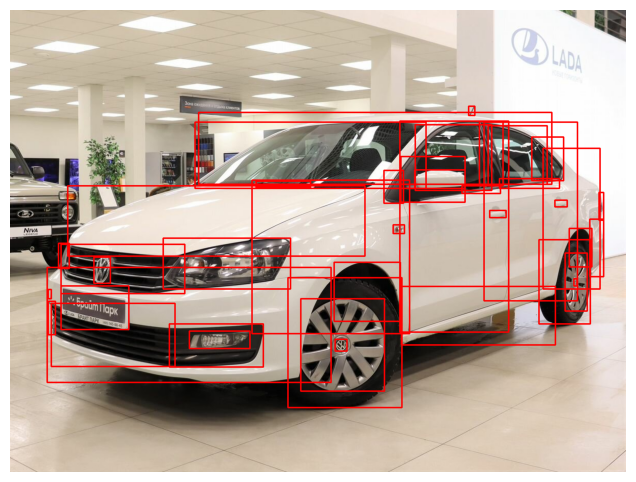

In [9]:
import cv2
import matplotlib.pyplot as plt

image_path = "/content/dataset/items/1.jfif"
label_path = "/content/dataset/labels/1.txt"


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

with open(label_path, "r") as f:
    annotations = f.readlines()

for ann in annotations:
    parts = ann.strip().split()
    class_id, x_center, y_center, width, height = map(float, parts)

    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)

    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

работает, пока по-простому, модель без сегментации попробую

скачаю предобученную модельку yolov5

In [3]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5 && pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17360, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 17360 (delta 36), reused 18 (delta 18), pack-reused 17308 (from 2)
Receiving objects: 100% (17360/17360), 16.25 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (11901/11901), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━

In [16]:
!pip install albumentations

In [19]:
import os
import glob
import cv2
import numpy as np
import albumentations as A

def convert_yolo_to_albumentations(yolo_bbox, img_w, img_h):
    x_center, y_center, width, height = yolo_bbox
    x_min = (x_center - width / 2) * img_w
    y_min = (y_center - height / 2) * img_h
    x_max = (x_center + width / 2) * img_w
    y_max = (y_center + height / 2) * img_h
    return [x_min, y_min, x_max, y_max]

def convert_albumentations_to_yolo(alb_bbox, img_w, img_h):
    x_min, y_min, x_max, y_max = alb_bbox
    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h
    return [x_center, y_center, width, height]

def clip_bbox(bbox, img_w, img_h):
    x_min, y_min, x_max, y_max = bbox
    x_min = max(0, min(x_min, img_w))
    y_min = max(0, min(y_min, img_h))
    x_max = max(0, min(x_max, img_w))
    y_max = max(0, min(y_max, img_h))
    return x_min, y_min, x_max, y_max

IMAGES_DIR = "/content/dataset/items"
LABELS_DIR = "/content/dataset/labels"
MASKS_DIR = "/content/dataset/mask"
OUTPUT_IMAGES_DIR = "augmented_images"
OUTPUT_LABELS_DIR = "augmented_labels"
OUTPUT_MASKS_DIR = "augmented_masks"

os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASKS_DIR, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def read_yolo_annotations(label_path, img_w, img_h):
    bboxes = []
    class_labels = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split()
            class_id = int(data[0])
            bbox = list(map(float, data[1:]))
            alb_bbox = convert_yolo_to_albumentations(bbox, img_w, img_h)
            bboxes.append(alb_bbox)
            class_labels.append(class_id)
    return bboxes, class_labels

def write_yolo_annotations(output_path, bboxes, class_labels, img_w, img_h):
    with open(output_path, "w") as f:
        for cls, bbox in zip(class_labels, bboxes):
            yolo_bbox = convert_albumentations_to_yolo(bbox, img_w, img_h)
            f.write(f"{cls} " + " ".join(map(str, yolo_bbox)) + "\n")

image_paths = glob.glob(os.path.join(IMAGES_DIR, "*.jfif"))

for image_path in image_paths:
    filename = os.path.basename(image_path).split('.')[0]
    label_path = os.path.join(LABELS_DIR, f"{filename}.txt")
    mask_path = os.path.join(MASKS_DIR, f"{filename}.png")

    if not os.path.exists(label_path) or not os.path.exists(mask_path):
        print(f"Пропускаем {filename} — нет аннотации или маски")
        continue

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    h, w, _ = image.shape
    bboxes, class_labels = read_yolo_annotations(label_path, w, h)

    bboxes = [clip_bbox(bbox, w, h) for bbox in bboxes]

    augmented = transform(image=image, mask=mask, bboxes=bboxes, class_labels=class_labels)

    aug_image = augmented["image"]
    aug_mask = augmented["mask"]
    aug_bboxes = augmented["bboxes"]
    aug_labels = augmented["class_labels"]

    aug_bboxes = [clip_bbox(bbox, w, h) for bbox in aug_bboxes]

    if not aug_bboxes:
        print(f"Пропускаем {filename}_aug — все боксы вышли за границы")
        continue

    new_filename = f"{filename}_aug"
    cv2.imwrite(os.path.join(OUTPUT_IMAGES_DIR, f"{new_filename}.jpg"), aug_image)
    cv2.imwrite(os.path.join(OUTPUT_MASKS_DIR, f"{new_filename}.png"), aug_mask)
    write_yolo_annotations(os.path.join(OUTPUT_LABELS_DIR, f"{new_filename}.txt"), aug_bboxes, aug_labels, w, h)

print("Аугментации завершены без ошибок!")

✅ Аугментации завершены без ошибок!


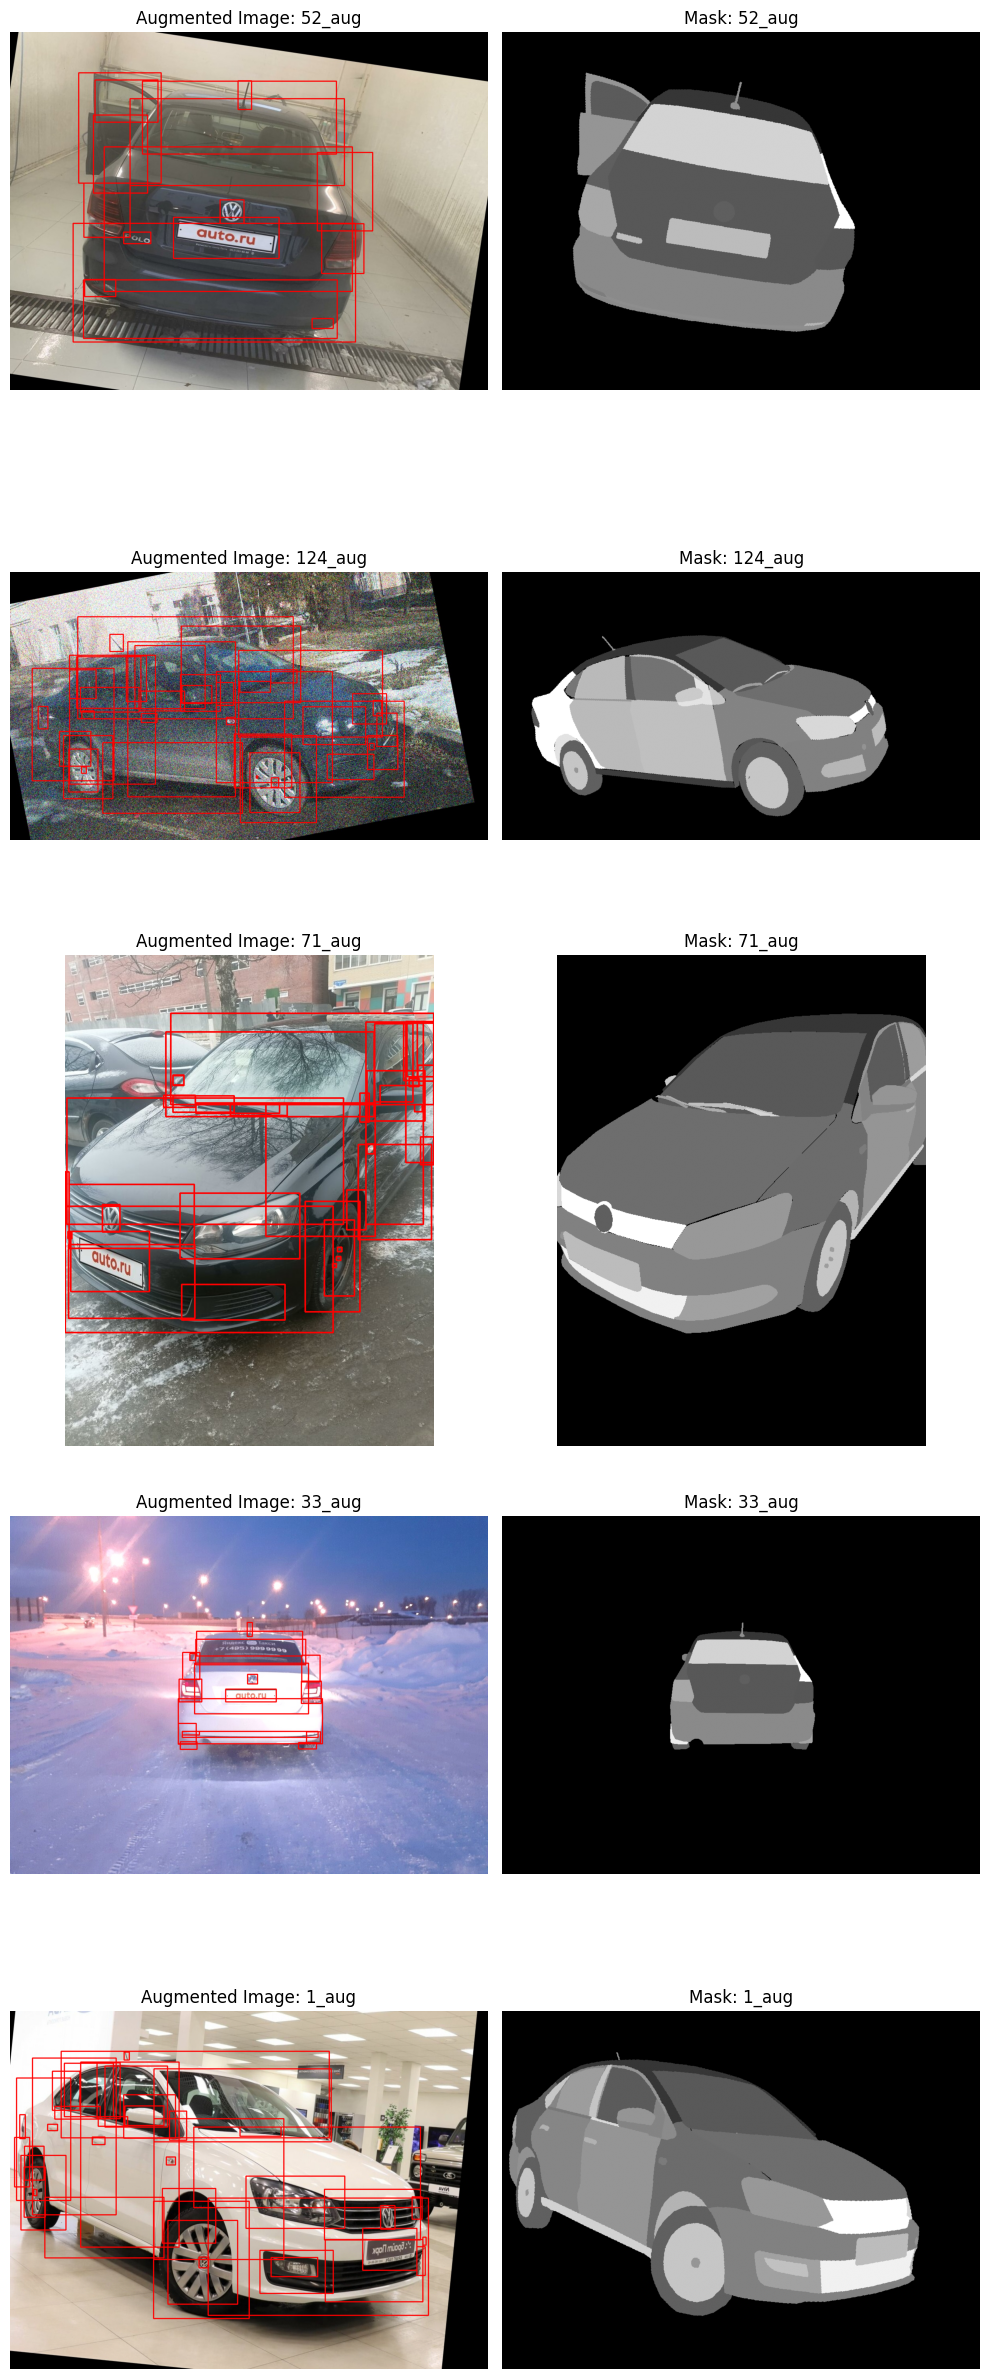

In [21]:
import matplotlib.pyplot as plt
import random

def show_augmented_samples(num_samples=5):
    aug_image_paths = glob.glob(os.path.join(OUTPUT_IMAGES_DIR, "*.jpg"))

    if len(aug_image_paths) == 0:
        print("Нет аугментированных изображений")
        return

    random.shuffle(aug_image_paths)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img_path = aug_image_paths[i]
        filename = os.path.basename(img_path).split('.')[0]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(OUTPUT_MASKS_DIR, f"{filename}.png"), cv2.IMREAD_GRAYSCALE)

        label_path = os.path.join(OUTPUT_LABELS_DIR, f"{filename}.txt")
        h, w, _ = image.shape
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                bboxes = [line.strip().split() for line in f.readlines()]

            for bbox in bboxes:
                class_id, x_center, y_center, width, height = map(float, bbox)
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Augmented Image: {filename}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {filename}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

show_augmented_samples()

In [24]:
!zip -r /content/img.zip /content/augmented_images

  adding: content/augmented_images/ (stored 0%)
  adding: content/augmented_images/115_aug.jpg (deflated 0%)
  adding: content/augmented_images/96_aug.jpg (deflated 3%)
  adding: content/augmented_images/114_aug.jpg (deflated 0%)
  adding: content/augmented_images/36_aug.jpg (deflated 0%)
  adding: content/augmented_images/63_aug.jpg (deflated 0%)
  adding: content/augmented_images/44_aug.jpg (deflated 0%)
  adding: content/augmented_images/6_aug.jpg (deflated 0%)
  adding: content/augmented_images/117_aug.jpg (deflated 1%)
  adding: content/augmented_images/66_aug.jpg (deflated 0%)
  adding: content/augmented_images/78_aug.jpg (deflated 0%)
  adding: content/augmented_images/79_aug.jpg (deflated 0%)
  adding: content/augmented_images/25_aug.jpg (deflated 6%)
  adding: content/augmented_images/110_aug.jpg (deflated 1%)
  adding: content/augmented_images/123_aug.jpg (deflated 0%)
  adding: content/augmented_images/19_aug.jpg (deflated 3%)
  adding: content/augmented_images/121_aug.jpg (

In [26]:
!zip -r /content/lbl.zip /content/augmented_labels

  adding: content/augmented_labels/ (stored 0%)
  adding: content/augmented_labels/22_aug.txt (deflated 52%)
  adding: content/augmented_labels/67_aug.txt (deflated 51%)
  adding: content/augmented_labels/8_aug.txt (deflated 52%)
  adding: content/augmented_labels/52_aug.txt (deflated 51%)
  adding: content/augmented_labels/104_aug.txt (deflated 51%)
  adding: content/augmented_labels/126_aug.txt (deflated 51%)
  adding: content/augmented_labels/110_aug.txt (deflated 51%)
  adding: content/augmented_labels/89_aug.txt (deflated 51%)
  adding: content/augmented_labels/24_aug.txt (deflated 52%)
  adding: content/augmented_labels/51_aug.txt (deflated 51%)
  adding: content/augmented_labels/63_aug.txt (deflated 51%)
  adding: content/augmented_labels/128_aug.txt (deflated 51%)
  adding: content/augmented_labels/27_aug.txt (deflated 51%)
  adding: content/augmented_labels/130_aug.txt (deflated 51%)
  adding: content/augmented_labels/58_aug.txt (deflated 51%)
  adding: content/augmented_label

In [25]:
!zip -r /content/msk.zip /content/augmented_masks

  adding: content/augmented_masks/ (stored 0%)
  adding: content/augmented_masks/37_aug.png (deflated 29%)
  adding: content/augmented_masks/9_aug.png (deflated 17%)
  adding: content/augmented_masks/49_aug.png (deflated 15%)
  adding: content/augmented_masks/123_aug.png (deflated 12%)
  adding: content/augmented_masks/69_aug.png (deflated 13%)
  adding: content/augmented_masks/59_aug.png (deflated 13%)
  adding: content/augmented_masks/27_aug.png (deflated 17%)
  adding: content/augmented_masks/39_aug.png (deflated 21%)
  adding: content/augmented_masks/79_aug.png (deflated 12%)
  adding: content/augmented_masks/116_aug.png (deflated 20%)
  adding: content/augmented_masks/84_aug.png (deflated 22%)
  adding: content/augmented_masks/81_aug.png (deflated 20%)
  adding: content/augmented_masks/82_aug.png (deflated 14%)
  adding: content/augmented_masks/71_aug.png (deflated 16%)
  adding: content/augmented_masks/28_aug.png (deflated 15%)
  adding: content/augmented_masks/45_aug.png (deflat

In [23]:
!zip -r /content/data.zip /content/dataset

  adding: content/dataset/ (stored 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/ (stored 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/ (stored 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/1200x900n - 2023-03-03T184714.238.jfif (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/1200x900n (1794).jfif (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/1200x900n (1799).jfif (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/photo_5278376925905145427_y.jpg (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/photo_3_2023-07-14_15-24-20.jpg (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/photo_18_2023-07-14_15-24-20.jpg (deflated 1%)
  adding: content/dataset/dataloop_dataset_converted_jsons/items/1200x900n (1796).jfif (deflated 0%)
  adding: content/dataset/dataloop_dataset_converted_jso

In [22]:
import os
import cv2
import glob

IMAGES_DIR = "/content/dataset/items"

jfif_paths = glob.glob(os.path.join(IMAGES_DIR, "*.jfif"))

for jfif_path in jfif_paths:
    image = cv2.imread(jfif_path)

    jpg_path = jfif_path.replace(".jfif", ".jpg")

    cv2.imwrite(jpg_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

    os.remove(jfif_path)

    print(f" {jfif_path} → {jpg_path}")

print("Все файлы успешно перезаписаны в .jpg")

 /content/dataset/items/86.jfif → /content/dataset/items/86.jpg
 /content/dataset/items/17.jfif → /content/dataset/items/17.jpg
 /content/dataset/items/33.jfif → /content/dataset/items/33.jpg
 /content/dataset/items/41.jfif → /content/dataset/items/41.jpg
 /content/dataset/items/128.jfif → /content/dataset/items/128.jpg
 /content/dataset/items/44.jfif → /content/dataset/items/44.jpg
 /content/dataset/items/117.jfif → /content/dataset/items/117.jpg
 /content/dataset/items/60.jfif → /content/dataset/items/60.jpg
 /content/dataset/items/101.jfif → /content/dataset/items/101.jpg
 /content/dataset/items/82.jfif → /content/dataset/items/82.jpg
 /content/dataset/items/87.jfif → /content/dataset/items/87.jpg
 /content/dataset/items/58.jfif → /content/dataset/items/58.jpg
 /content/dataset/items/89.jfif → /content/dataset/items/89.jpg
 /content/dataset/items/63.jfif → /content/dataset/items/63.jpg
 /content/dataset/items/78.jfif → /content/dataset/items/78.jpg
 /content/dataset/items/23.jfif → 

In [26]:
import zipfile
import os

zip_path = "/content/daaat.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [29]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")
model.train(data="/content/dat/data.yaml", epochs=10, imgsz=640)

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/dat/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /content/dat/items/train.cache... 0 images, 132 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/dat/items/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dat/items/val.cache... 0 images, 132 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/dat/items/val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train7/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000128, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.32G          0        810          0          0        640: 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.44G          0      788.8          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.44G          0      361.4          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.44G          0      238.2          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.44G          0      195.1          0          0        640: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.44G          0      168.5          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.44G          0      155.2          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.44G          0      146.3          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.44G          0      139.8          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.44G          0      135.3          0          0        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



10 epochs completed in 0.017 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 22.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,154,222 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:491: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.05)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.05)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_m

                   all        132          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9646c352d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [27]:
import os

folder_path = "/content/daaat/labels/train"

for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        corrected_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                parts[0] = str(int(float(parts[0])))
                corrected_lines.append(" ".join(parts))

        with open(file_path, "w") as f:
            f.write("\n".join(corrected_lines))

print("Все файлы исправлены")

Все файлы исправлены


In [28]:
!ls /content/dat/labels/train

100_aug.txt  116_aug.txt  131_aug.txt  27_aug.txt  42_aug.txt  58_aug.txt  73_aug.txt  89_aug.txt
101_aug.txt  117_aug.txt  132_aug.txt  28_aug.txt  43_aug.txt  59_aug.txt  74_aug.txt  8_aug.txt
102_aug.txt  118_aug.txt  13_aug.txt   29_aug.txt  44_aug.txt  5_aug.txt   75_aug.txt  90_aug.txt
103_aug.txt  119_aug.txt  14_aug.txt   2_aug.txt   45_aug.txt  60_aug.txt  76_aug.txt  91_aug.txt
104_aug.txt  11_aug.txt   15_aug.txt   30_aug.txt  46_aug.txt  61_aug.txt  77_aug.txt  92_aug.txt
105_aug.txt  120_aug.txt  16_aug.txt   31_aug.txt  47_aug.txt  62_aug.txt  78_aug.txt  93_aug.txt
106_aug.txt  121_aug.txt  17_aug.txt   32_aug.txt  48_aug.txt  63_aug.txt  79_aug.txt  94_aug.txt
107_aug.txt  122_aug.txt  18_aug.txt   33_aug.txt  49_aug.txt  64_aug.txt  7_aug.txt   95_aug.txt
108_aug.txt  123_aug.txt  19_aug.txt   34_aug.txt  4_aug.txt   65_aug.txt  80_aug.txt  96_aug.txt
109_aug.txt  124_aug.txt  1_aug.txt    35_aug.txt  50_aug.txt  66_aug.txt  81_aug.txt  97_aug.txt
10_aug.txt   125_aug.


image 1/1 /content/dt/items/1.jpg: 480x640 (no detections), 18.4ms
Speed: 6.6ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


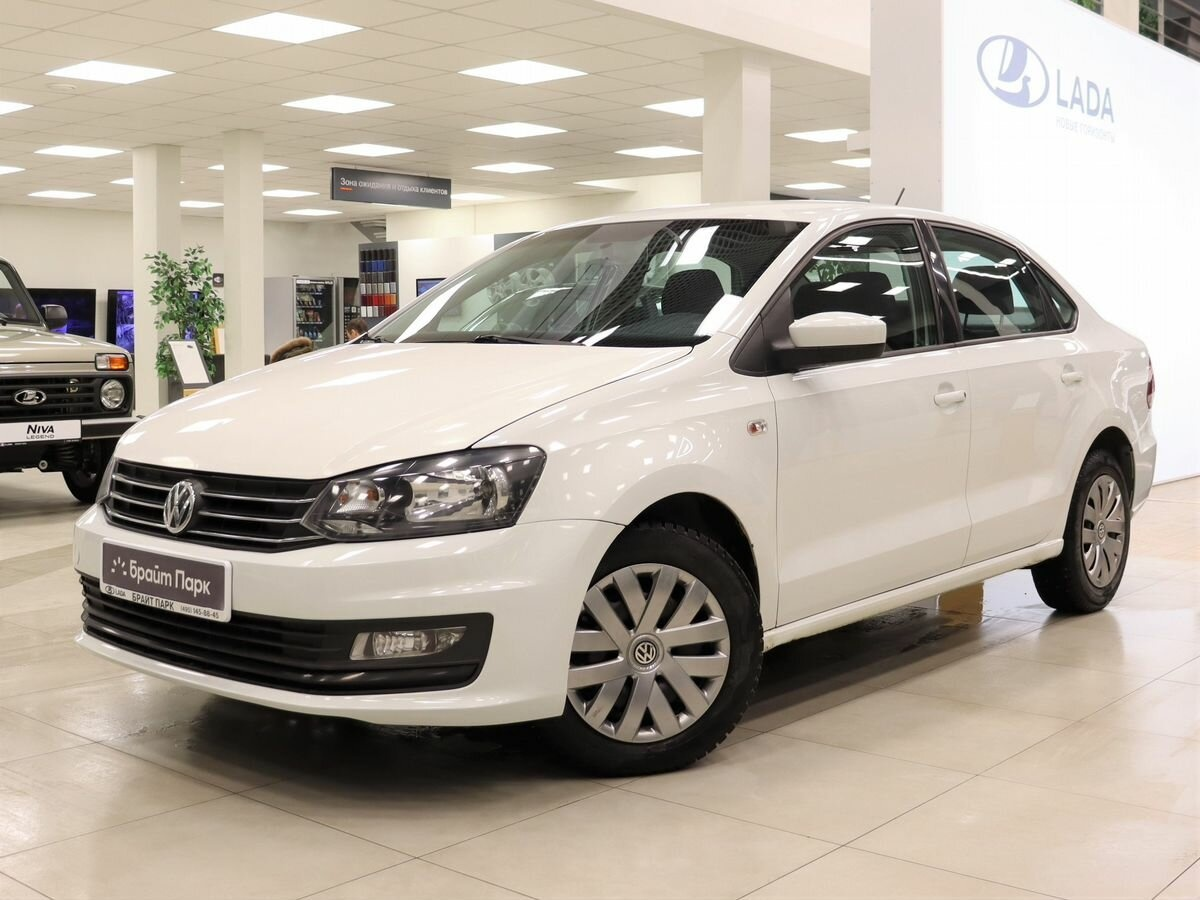

In [14]:
results = model.predict("/content/dt/items/1.jpg")
for result in results:
    result.show()